In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import nltk
import re
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import os

In [2]:
#import data: sourced from kaggle
data = pd.read_csv('consumer-complaints-NLP.csv', encoding='latin-1')
data.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id
0,2017-03-21,Credit reporting,NaN,Incorrect information on credit report,Information is not mine,NaN,Company has responded to the consumer and the ...,EXPERIAN DELAWARE GP,TX,77075,Older American,NaN,Phone,2017-03-21,Closed with non-monetary relief,True,No,2397100
1,2017-04-19,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not disclosed as an attempt to collect,NaN,NaN,"Security Credit Services, LLC",IL,60643,NaN,NaN,Web,2017-04-20,Closed with explanation,True,No,2441777
2,2017-04-19,Credit card,NaN,Other,NaN,NaN,Company has responded to the consumer and the ...,"CITIBANK, N.A.",IL,62025,NaN,NaN,Referral,2017-04-20,Closed with explanation,True,No,2441830
3,2017-04-14,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,Company believes it acted appropriately as aut...,"Shellpoint Partners, LLC",CA,90305,NaN,NaN,Referral,2017-04-14,Closed with explanation,True,No,2436165
4,2017-04-19,Credit card,NaN,Credit determination,NaN,NaN,Company has responded to the consumer and the ...,U.S. BANCORP,LA,70571,NaN,NaN,Postal mail,2017-04-21,Closed with explanation,True,No,2441726


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777959 entries, 0 to 777958
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 777959 non-null  object
 1   product                       777959 non-null  object
 2   sub_product                   542822 non-null  object
 3   issue                         777959 non-null  object
 4   sub_issue                     320986 non-null  object
 5   consumer_complaint_narrative  157865 non-null  object
 6   company_public_response       197884 non-null  object
 7   company                       777959 non-null  object
 8   state                         772056 non-null  object
 9   zip_code                      772001 non-null  object
 10  tags                          109264 non-null  object
 11  consumer_consent_provided     288311 non-null  object
 12  submitted_via                 777959 non-null  object
 13 

In [4]:
#selecting needed columns
data = data[['product', 'consumer_complaint_narrative']]
data.head()

,product,consumer_complaint_narrative
0,Credit reporting,NaN
1,Debt collection,NaN
2,Credit card,NaN
3,Mortgage,NaN
4,Credit card,NaN


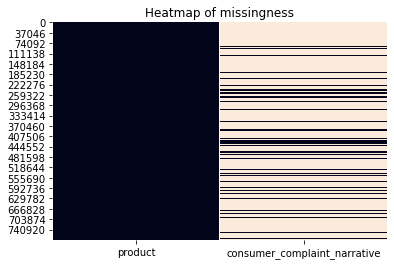

In [5]:
#missing heat map
sns.heatmap(data.isnull(), cbar=False)
plt.title('Heatmap of missingness')
plt.show()

In [6]:
np.sum(data.isnull())

product                              0
consumer_complaint_narrative    620094
dtype: int64

In [7]:
#remove na from consumer_complaint_narrative 
data = data[pd.notnull(data['consumer_complaint_narrative'])]

In [8]:
np.sum(data.isnull())

product                         0
consumer_complaint_narrative    0
dtype: int64

In [9]:
data.head()

,product,consumer_complaint_narrative
9,Mortgage,Started the refinance of home mortgage process...
19,Bank account or service,My wife and I visited the Chase Bank branch at...
23,Student loan,The service representative was harsh and not l...
30,Bank account or service,I have documentation that shows that US Bank w...
38,Credit reporting,Experian reporting of XXXX XXXX reflects a for...


In [10]:
#factorize product column into categories
data['category_id'] = data['product'].factorize()[0]
data.head()

,product,consumer_complaint_narrative,category_id
9,Mortgage,Started the refinance of home mortgage process...,0
19,Bank account or service,My wife and I visited the Chase Bank branch at...,1
23,Student loan,The service representative was harsh and not l...,2
30,Bank account or service,I have documentation that shows that US Bank w...,1
38,Credit reporting,Experian reporting of XXXX XXXX reflects a for...,3


In [11]:
data['category_id'].nunique()

12

In [12]:
data.groupby('product').count()

,consumer_complaint_narrative,category_id
product,,
Bank account or service,14500,14500
Consumer Loan,9029,9029
Credit card,18276,18276
Credit reporting,30319,30319
Debt collection,38741,38741
Money transfers,1437,1437
Mortgage,32000,32000
Other financial service,272,272
Payday loan,1695,1695


Visualizing data distribution on pie chart

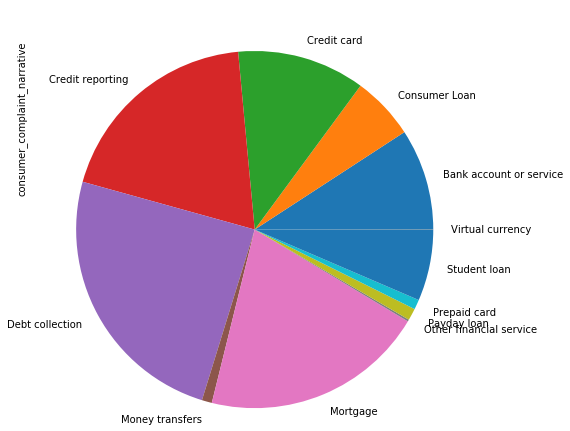

In [13]:
fig = plt.figure(figsize=(8,6))
data.groupby('product').consumer_complaint_narrative.count().plot.pie(ylim=0)
plt.show()

Visualizing data distribution on bar plot

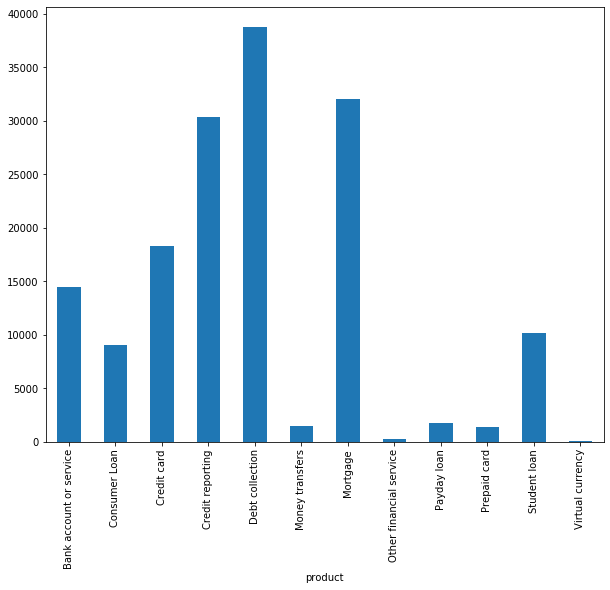

In [14]:
fig = plt.figure(figsize=(10,8))
data.groupby('product').consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [15]:
categ = data.groupby('product').agg({"consumer_complaint_narrative": ' | '.join})

In [16]:
categ

,consumer_complaint_narrative
product,
Bank account or service,My wife and I visited the Chase Bank branch at...
Consumer Loan,I have leased a vehicle XX/XX/2015 from an aut...
Credit card,Around XX/XX/XXXX I accepted a credit card off...
Credit reporting,Experian reporting of XXXX XXXX reflects a for...
Debt collection,i gave a vehicle away signed a bill of sale an...
Money transfers,Moneygram is applying arbitrary rules to block...
Mortgage,Started the refinance of home mortgage process...
Other financial service,I bought a money order from XXXX XXXX to pay a...
Payday loan,XXXX XXXX started calling all my family member...


Wordcloud analysis of credit reporting

In [17]:
#data extraction
credit_repo = categ.iloc[3,0]

In [18]:
#preprocsessing for visualization
def review_to_words(raw_review):
    bs = BeautifulSoup(raw_review).get_text()
    letters_only = re.sub('[^a-zA-Z]', ' ', bs)
    #tokenization
    words_only = letters_only.lower().split()
    stops = set(stopwords.words('english'))
    words = [w for w in words_only if not w in stops]
    return (" ".join(words))

In [20]:
clean_credit_repo = str(review_to_words(credit_repo))

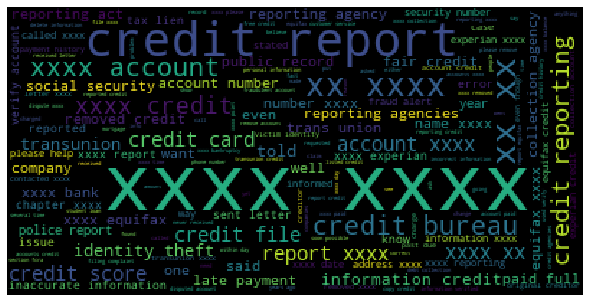

In [21]:
wordcloud = WordCloud().generate(clean_credit_repo) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [22]:
#re-analyzing the complains without the xxxx words
cleaned_credit_repo = clean_credit_repo.replace ('xxxx','')

In [23]:
cleaned_credit_repo = clean_credit_repo.replace ('xx','')

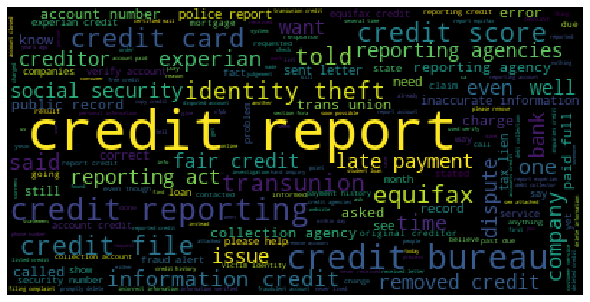

In [24]:
wordcloud = WordCloud().generate(cleaned_credit_repo) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

Wordcloud analysis of Mortgage complains

In [25]:
#data extraction
mortg = categ.iloc[6,0]

In [26]:
#preprocsessing for visualization
def review_to_words(raw_review):
    bs = BeautifulSoup(raw_review).get_text()
    letters_only = re.sub('[^a-zA-Z]', ' ', bs)
    words_only = letters_only.lower().split()
    stops = set(stopwords.words('english'))
    words = [w for w in words_only if not w in stops]
    return (" ".join(words))

In [27]:
cleaned_mortg = str(review_to_words(mortg)).replace('xxxx', '').replace('xx','')

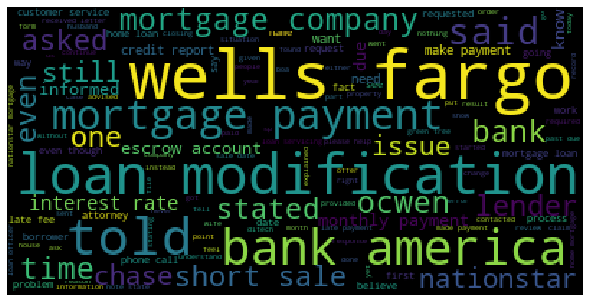

In [28]:
wordcloud = WordCloud().generate(cleaned_mortg) 
  
# plottin the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

Wordcloud analysis of Debt collection complains

In [29]:
#data extraction
dc = categ.iloc[4,0]
#cleaning function for visualization
def review_to_words(raw_review):
    bs = BeautifulSoup(raw_review).get_text()
    letters_only = re.sub('[^a-zA-Z]', ' ', bs)
    words_only = letters_only.lower().split()
    stops = set(stopwords.words('english'))
    words = [w for w in words_only if not w in stops]
    return (" ".join(words))

In [30]:
#conversion to string from unicode and futher cleaning
cleaned_dc = str(review_to_words(dc)).replace('xxxx', '').replace('xx','')

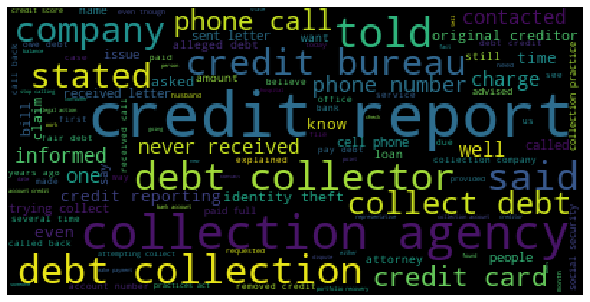

In [31]:
wordcloud = WordCloud().generate(cleaned_dc) 
  
# plottin the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

Modelling

In [34]:
#splitting the data
x_train, x_test, y_train, y_test = model_selection.train_test_split(data['consumer_complaint_narrative'], data['product'])

In [35]:
#word emedding using term frequency - inverse document frequency TFIDF
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

tfidf_vec = TfidfVectorizer(analyzer='word',
                           token_pattern=r'\w{1,}',
                            max_features=5000)
tfidf_vec.fit(data['consumer_complaint_narrative'])
xtrain_tfidf = tfidf_vec.transform(x_train)
xtest_tfidf = tfidf_vec.transform(x_test)

In [36]:
#modelling
model = linear_model.LogisticRegression(solver='newton-cg', 
                                        multi_class='multinomial').fit(xtrain_tfidf, 
                                                                       y_train)

In [37]:
#checking accuracy
accuracy = metrics.accuracy_score(model.predict(xtest_tfidf), y_test)
print("Accuracy: ", accuracy)

Accuracy:  0.8563863480882763


In [38]:
#classification report
print(metrics.classification_report(y_test, model.predict(xtest_tfidf), 
                                    target_names=data['product'].unique()))

                         precision    recall  f1-score   support

               Mortgage       0.83      0.81      0.82      3732
Bank account or service       0.77      0.66      0.71      2192
           Student loan       0.82      0.83      0.82      4605
       Credit reporting       0.87      0.87      0.87      7557
            Credit card       0.82      0.89      0.85      9632
        Debt collection       0.76      0.57      0.65       365
          Consumer Loan       0.93      0.95      0.94      7994
Other financial service       0.00      0.00      0.00        61
        Money transfers       0.67      0.37      0.48       419
           Prepaid card       0.83      0.61      0.70       357
            Payday loan       0.92      0.86      0.89      2550
       Virtual currency       0.00      0.00      0.00         3

               accuracy                           0.86     39467
              macro avg       0.69      0.62      0.65     39467
           weighted avg

C:\Users\Moaaz\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Applying the model - 1

In [39]:
complain = ["This company refuses to provide me verification and validation of debt"
            + "per my right under the FDCPA.I do not believe this debt is mine."]

text_features = tfidf_vec.transform(complain)
predictions = model.predict(text_features)
print(complain)
print('Is predicted as: {}'.format(data.loc[data['category_id']==predictions[0], 
                                            'product'].iloc[0]))

['This company refuses to provide me verification and validation of debtper my right under the FDCPA.I do not believe this debt is mine.']
Is predicted as: Credit card


Applying the model - 2

In [40]:
complain = ["I am writing to your company about a problem with my Hoverbike, a 2012 Skylark model. I began to have trouble staying aloft a few months ago, and this week the height control module completely failed. While the bicycle is a few months out of warranty, I believe that this occurred because of a design flaw in the Skylark, and I am asking that your company cover or share with me the cost of the required repair."]

text_features = tfidf_vec.transform(complain)
predictions = model.predict(text_features)
print(complain)
print('Is predicted as: {}'.format(data.loc[data['category_id']==predictions[0], 
                                            'product'].iloc[0]))

['I am writing to your company about a problem with my Hoverbike, a 2012 Skylark model. I began to have trouble staying aloft a few months ago, and this week the height control module completely failed. While the bicycle is a few months out of warranty, I believe that this occurred because of a design flaw in the Skylark, and I am asking that your company cover or share with me the cost of the required repair.']
Is predicted as: Credit card
